# Introduction to CNNs and CNN concepts

If you want to run PyTorch code on your GPU locally, follow [these](https://pytorch.org/get-started/locally/) instructions.

## Business stakeholders

Engineers:
- DS / MLE: develop workflow and model
- Data engineer: responsible for data pipelines for dev and prod
- Software engineer (platform engineer): reponsible for production environment (front-end and back-end)
- DevOps engineer: responsible for the computing infrastructure

Business:
- Product Manager: helps define product requirements, goals, and relevant metrics. Keeps project on track.
- Customer: customer of the product.

## History of CNNS

Timeline:
- 1958: Perceptron: a one-neuron primitive neural network capable of classifying linearly-separable datasets.
- 1980: Neocognitron: a neural network using two types of mechanisms that are the basis of modern CNNs: convolution and pooling.
- 1986: First multi-layer perceptron
- 1986: Introduction of backpropagation: allows training of neural networks end to end based on data.
- 1998: First practical application: LeNet
- 2010: Start of ImageNet competition

# CNN Concepts

Goal of this lesson:
- learn general concepts underlying Convolutional Neural Networks (CNNs) and;
- how CNNs relate to Multi-Layer Perceptrons (MLPs)

The famous MNIST dataset is used to demonstrate MLPs and CNNs for image classification.

## How computer interpret images

Definitions:
- Vector: an array of numbers with only one dimension
- Matrix: an array of numbers with two dimensions
- Array or tensor: two interchangeable generic terms which can mean arrays with one, two, or n dimensions

An image is seen by the computer as an array of values (a matrix):
- MNIST dataset are 28 x 28 pixels and 8-bit grayscale
- values in square matrix represents the light intsensity with a range of 0 to 255: 0 means pure black and 255 means pure white

Normalisation:
- scaling the matrix values between 0 and 1 by dividing each element by 255
- normalisation helps to train the network:
  - activation functions that are normally used in neural networks (sigmoid, ReLU, etc.,...) have the highest rate of change around 0
  - this means that their derivative is large for inputs that are not too far from 0

Flattening:
- a network takes a 1d array as input, while images are a 28x28 matrix
- therefore, we have to flatten the matrix: to stack all the rows of the matrix in one long 1d vector

Example of how a computer sees an image:

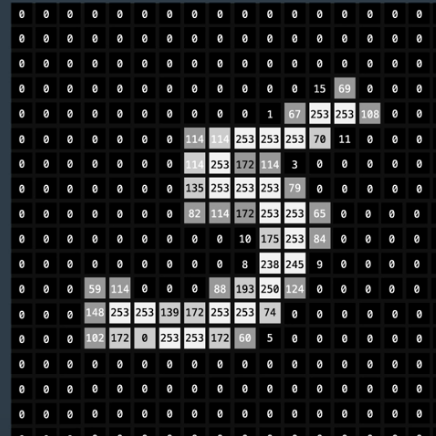

## Loss and optimization

Loss function:
- The loss function quantifies how far we are from the ideal state where the network does not make any mistakes and has perfect confidence in its answers

Learn from mistakes:
- Get the loss: measure any mistake between a predicted and a true class (e.g. cross-entropy)
  - answers how bad the model weights are
- Use backpropagation: to quantify how bad a particular weight is in making a mistake
- Optimization: gives us a way to calculate a better weight (e.g. gradient descent)

**Categorical Cross-Entropy (CCE)** loss function:
- most typical loss function for image classification
- loss is lower when prediction and label agree, and vice versa
- goal is to minimize this loss function

Optimizer: finding the lowest loss

## Loading and transforming image data

### Transforms
Operations we must perform before we can feed images to a neural network:
- normalize the images so the values in the pixels are floating point numbers between 0 and 1, or -1 and 1
- transform images to tensors
- often we also need resizing images (for later)

Code example:
```python
import torchvision.transforms as T

## T.Compose creates a pipeline where the provided
## transformations are run in sequence
transforms = T.Compose(
    [

        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        T.ToTensor(),

        # This then renormalizes the tensor to be between -1.0 and 1.0,
        # which is a better range for modern activation functions like
        # Relu
        T.Normalize((0.5), (0.5)),
    ]
)
```

### Datasets
In Pytorch:
- A `Dataset` instance provides methods to load and manipulate the data, whereas
- a `DataLoader` instance wraps the dataset and allows iterations over it during training, validation, and test.

Code example:
```python
train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transforms
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transforms
)
```

You can also extract images and labels from your own local directory `ImageFolder` class. Make sure to have the right folder structure.

Code example:
```python
from torchvision import datasets

train_data = datasets.ImageFolder(
  "/data/custom_data",
  transform=transforms
)
```

### Dataloaders

In Pytorch, a `Dataloader` allows sequential or random iterations over a dataset or over a subset of a dataset.

Code example:
```python
train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transforms
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_data, 
  shuffle=True, 
  batch_size=batch_size,
  num_workers=num_workers
)
```

A good rule of thumb is to use a number of workers equal to the number of CPUs on the current machine:
```python
import multiprocessing

n_workers = multiprocessing.cpu_count()
```

Once you have a dataloader, you can easily loop over all the data one batch at a time:
```python
for image_batch, label_batch in train_loader:
    ... do something ...
```

If all you want to do is obtain the next batch, then:
```python
## Get an iterator from the dataloader
dataiter = iter(train_loader)
## Get the next batch
image_batch, label_batch = dataiter.next()
```

### Splitting Train and Validation Data

Typical splits:
- training set, for training the model
- validation set, which is a subset of the training set, to do things like hyperparameter optimization and to prevent overfitting
- test set, for testing after the model has been trained

Code example:
```python
## Let's keep 80% of the training data for training
train_len = int(len(trainval_data) * 0.8)

## Let's use the remaining for validation
val_len = len(trainval_data) - train_len

## Perform a random split of the train dataset
train_subset, val_subset = torch.utils.data.random_split(
    trainval_data, [train_len, val_len]
)

## Now we can use the subsets as normal datasets
train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
```

## Structure of a Neural Netwerk in Pytorch

A model in PyTorch is implemented as a class with at least two methods: the `__init__` method and the `forward` method:
- the `__init__` method initializes all the layers that the model uses
- the `forward` method implements a forward pass through the network (i.e., it applies all the layers to the input)

Note that the backward pass for backpropagation is executed by PyTorch automatically and does not need to be implemented.

Code example of typical Pytorch model:
```python
import torch
import torch.nn as nn

class MyModel(nn.Module):

  def __init__(self):

    super().__init__()

    # Create layers. In this case just a standard MLP
    self.fc1 = nn.Linear(20, 10)
    self.relu1 = nn.ReLU()

    self.fc2 = nn.Linear(10, 3)

  def forward(self, x):

    # Call the layers in the appropriate sequence
    x = self.fc1(x)
    x = self.relu1(x)

    x = self.fc2(x)

    return x

# Make up some data
x = torch.rand(20)

m = MyModel()
out = m(x)
```

If the network is a simple sequential application of different layers, you can use the `nn.Sequential` method and save a lot of boilerplate code.

Code example when using `nn.Sequential`:
```python
import torch
import torch.nn as nn

class MyModel(nn.Module):

  def __init__(self):

    super().__init__()

    # Create layers. In this case just a standard MLP
    self.model = nn.Sequential(
      nn.Linear(20, 10),
      nn.ReLU(),
      nn.Linear(10, 3)
    )

  def forward(self, x):

    # nn.Sequential will call the layers 
    # in the order they have been inserted
    return self.model(x)
```

### Activation functions
The purpose of an activation function is to scale the outputs of a layer so that they are consistent, small values. Much like normalizing input values, this step ensures that our model trains efficiently!

### Optimizers
The optimizer determines the values of the parameters that minimize the loss function.

Example code of two common optimizers in Pytorch:
```python
import torch.optim

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
```

### Rules of thumb
Guidelines to get started with your architecture:
- `input_dim` is fixed, so the first layer must be a fully-connected (`Linear` in Pytorch) layer.
- also `output_dim` is fixed (the desired outputs). For a classification problem it is the number of classes `n_classes`, and for a regression problem it is 1 (or the number of continuous values to predict). So the output layer is a `Linear` layer with `n_classes` (in case of classification).
- for the hidden layers:
  - typically you want to start from only one hidden layer, with a number of neurons between the input and the output dimension. Sometimes adding a second hidden layer helps, and in rare cases you might need to add more than one.
  - as for the number of neurons in the hidden layers, a decent starting point is usually the mean between the input and the output dimension.
 
Perform experimentation to adjust the hyperparameters:
- if overfitting:
  - (1) add regularization like dropout and weight decay
  - (2) decrease the number of neurons in the hidden layer
  - Note: a larger network with a bit of drop-out learns multiple ways to arrive to the right answer, so it is more robust than a smaller network without dropout.
- if underfitting:
  - (1) add more neurons (start by approximating up to the closest power of 2)

### Visualising the architecture
To view the architecture of a Neural Network, you can save your model and open it in the [Netron.app](https://netron.app/) application.

Example code:
```python
import torch

scripted = torch.jit.script(model)
torch.jit.save(scripted, "my_network.pt")
```

## Training a Neural Network

Steps:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Example code of how to train a neural network in Pytorch:
```python
# number of epochs to train the model
n_epochs = 50

# Set model to training mode
# (this changes the behavior of some layers, like Dropout)
model.train()

# Loop over the epochs
for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0

    # Loop over all the dataset using the training
    # dataloader
    for data, target in train_dataloader:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: 
        # compute predictions
        output = model(data)

        # calculate the loss which compare the model
        # output for the current batch with the relative
        # ground truth (the target)
        loss = criterion(output, target)

        # backward pass: 
        # compute gradient of the loss with respect to 
        # model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
```

## Model validation

Definitions:
- Epoch: one complete pass through the entire training dataset. Typically you have a training epoch is followed by a validation epoch.
- Training set: used to update the model weights
- Validation set: used to check how well the model generalizes
- Test set: used to check the accuracy after training

When stopping training:
- when validation loss increases


## Evaluating and testing the network

After an training epoch, we perform a validation epoch to see how well the weights generalize:

Code example of validation loop in Pytorch:
```python
# Tell pytorch to stop computing gradients for the moment
# by using the torch.no_grad() context manager
with torch.no_grad():

  # set the model to evaluation mode
  # This changes the behavior of some layers like
  # Dropout with respect to their behavior during
  # training
  model.eval()

  # Keep track of the validation loss
  valid_loss = 0.0

  # Loop over the batches of validation data
  # (here we have removed the progress bar display that is
  # accomplished using tqdm in the video, for clarity)
  for batch_idx, (data, target) in enumerate(valid_dataloader):

    # 1. forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # 2. calculate the loss
    loss_value = criterion(output, target)

    # Calculate average validation loss
    valid_loss = valid_loss + (
      (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
    )

  # Print the losses 
  print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")
```

The test loop is similar to the validation loop, but then use the `test_dataloader` instead.

## MLPs versus CNNs

CNNs in general outperform MLPs on image classification tasks:
- MLPs flatten the image and therefore lose spatial information:
  - CNNs in contrary, don't need to flatten the image and therefore can learn that pixels that are close to eather are related to each other
 
Problems when using MLPs for image classification:
- MLPs only use fully-connected layers and therefore use **a lot of parameters**
  - e.g. the MLP from before for recognizing 28*28 images already contained over half a million paramterers
- MLPs only accept vectors as input
  - the 2D information therefore will be lost

CNNs are characterized by:
- **locally-connected layers**, i.e., layers where neurons are connected to only a limited numbers of input pixels (instead of all the pixels like in fully-connected layers)
  - it analyses groups of pixes at a time
- and **weights sharing**, which drastically reduces the number of parameters in the network compared to MLPs
  - weight sharing helps the netwerk to recognize the same pattern anywhere in the image
    

## Filters and the Convolutional Layer

Convolutional operation:
- to preserve the spatial information in the image
- it makes the network capable of extracting spatial and color patterns that characterize different objects

CNNs uses **filters** (also known as "kernels") to "extract" the features of an object (for example, edges):
- by using multiple different filters the network can learn to recognize complex shapes and objects.


### Image filters
Image filters are small matrices that can be used to transform the input image in specific ways, for example, highlighting edges of objects in the image.
- an **edge** of an object is a place in an image where the intensity changes significantly
- to detect these changes in intensity within an image, you can create specific image filters that look at groups of pixels and react to alternating patterns of dark/light pixels. These filters produce an output that shows edges of objects and differing textures.

### Frequency
Frequency in images is a **rate of change** in pixels:
- a high-frequency image is one where the intensity changes a lot. And the level of brightness changes quickly from one pixel to the next
  - **high-frequency components also correspond to the edges of objects in images**
- a low-frequency image may be one that is relatively uniform in brightness or changes very slowly

### High-pass filters
Used to:
- emphazises edges
- enhance high-frequency parts of an image

High-pass filters are based on convolutional kernels: a kernel is a matrix of numbers that modifies a pixel in an image (a small grid of numbers):
- kernel convolution relies on centering a pixel and looking at its surrounding neighbors
- it is most common to use for padding, cropping, or extension

Kernel operations:
- **Padding**: the image is padded with a border of 0's, black pixels.
- **Cropping**: any pixel in the output image which would require values from beyond the edge is skipped. This method can result in the output image being smaller then the input image, with the edges having been cropped.
- **Extension**: the nearest border pixels are conceptually extended as far as necessary to provide values for the convolution. Corner pixels are extended in 90° wedges. Other edge pixels are extended in lines.

Example kernels:
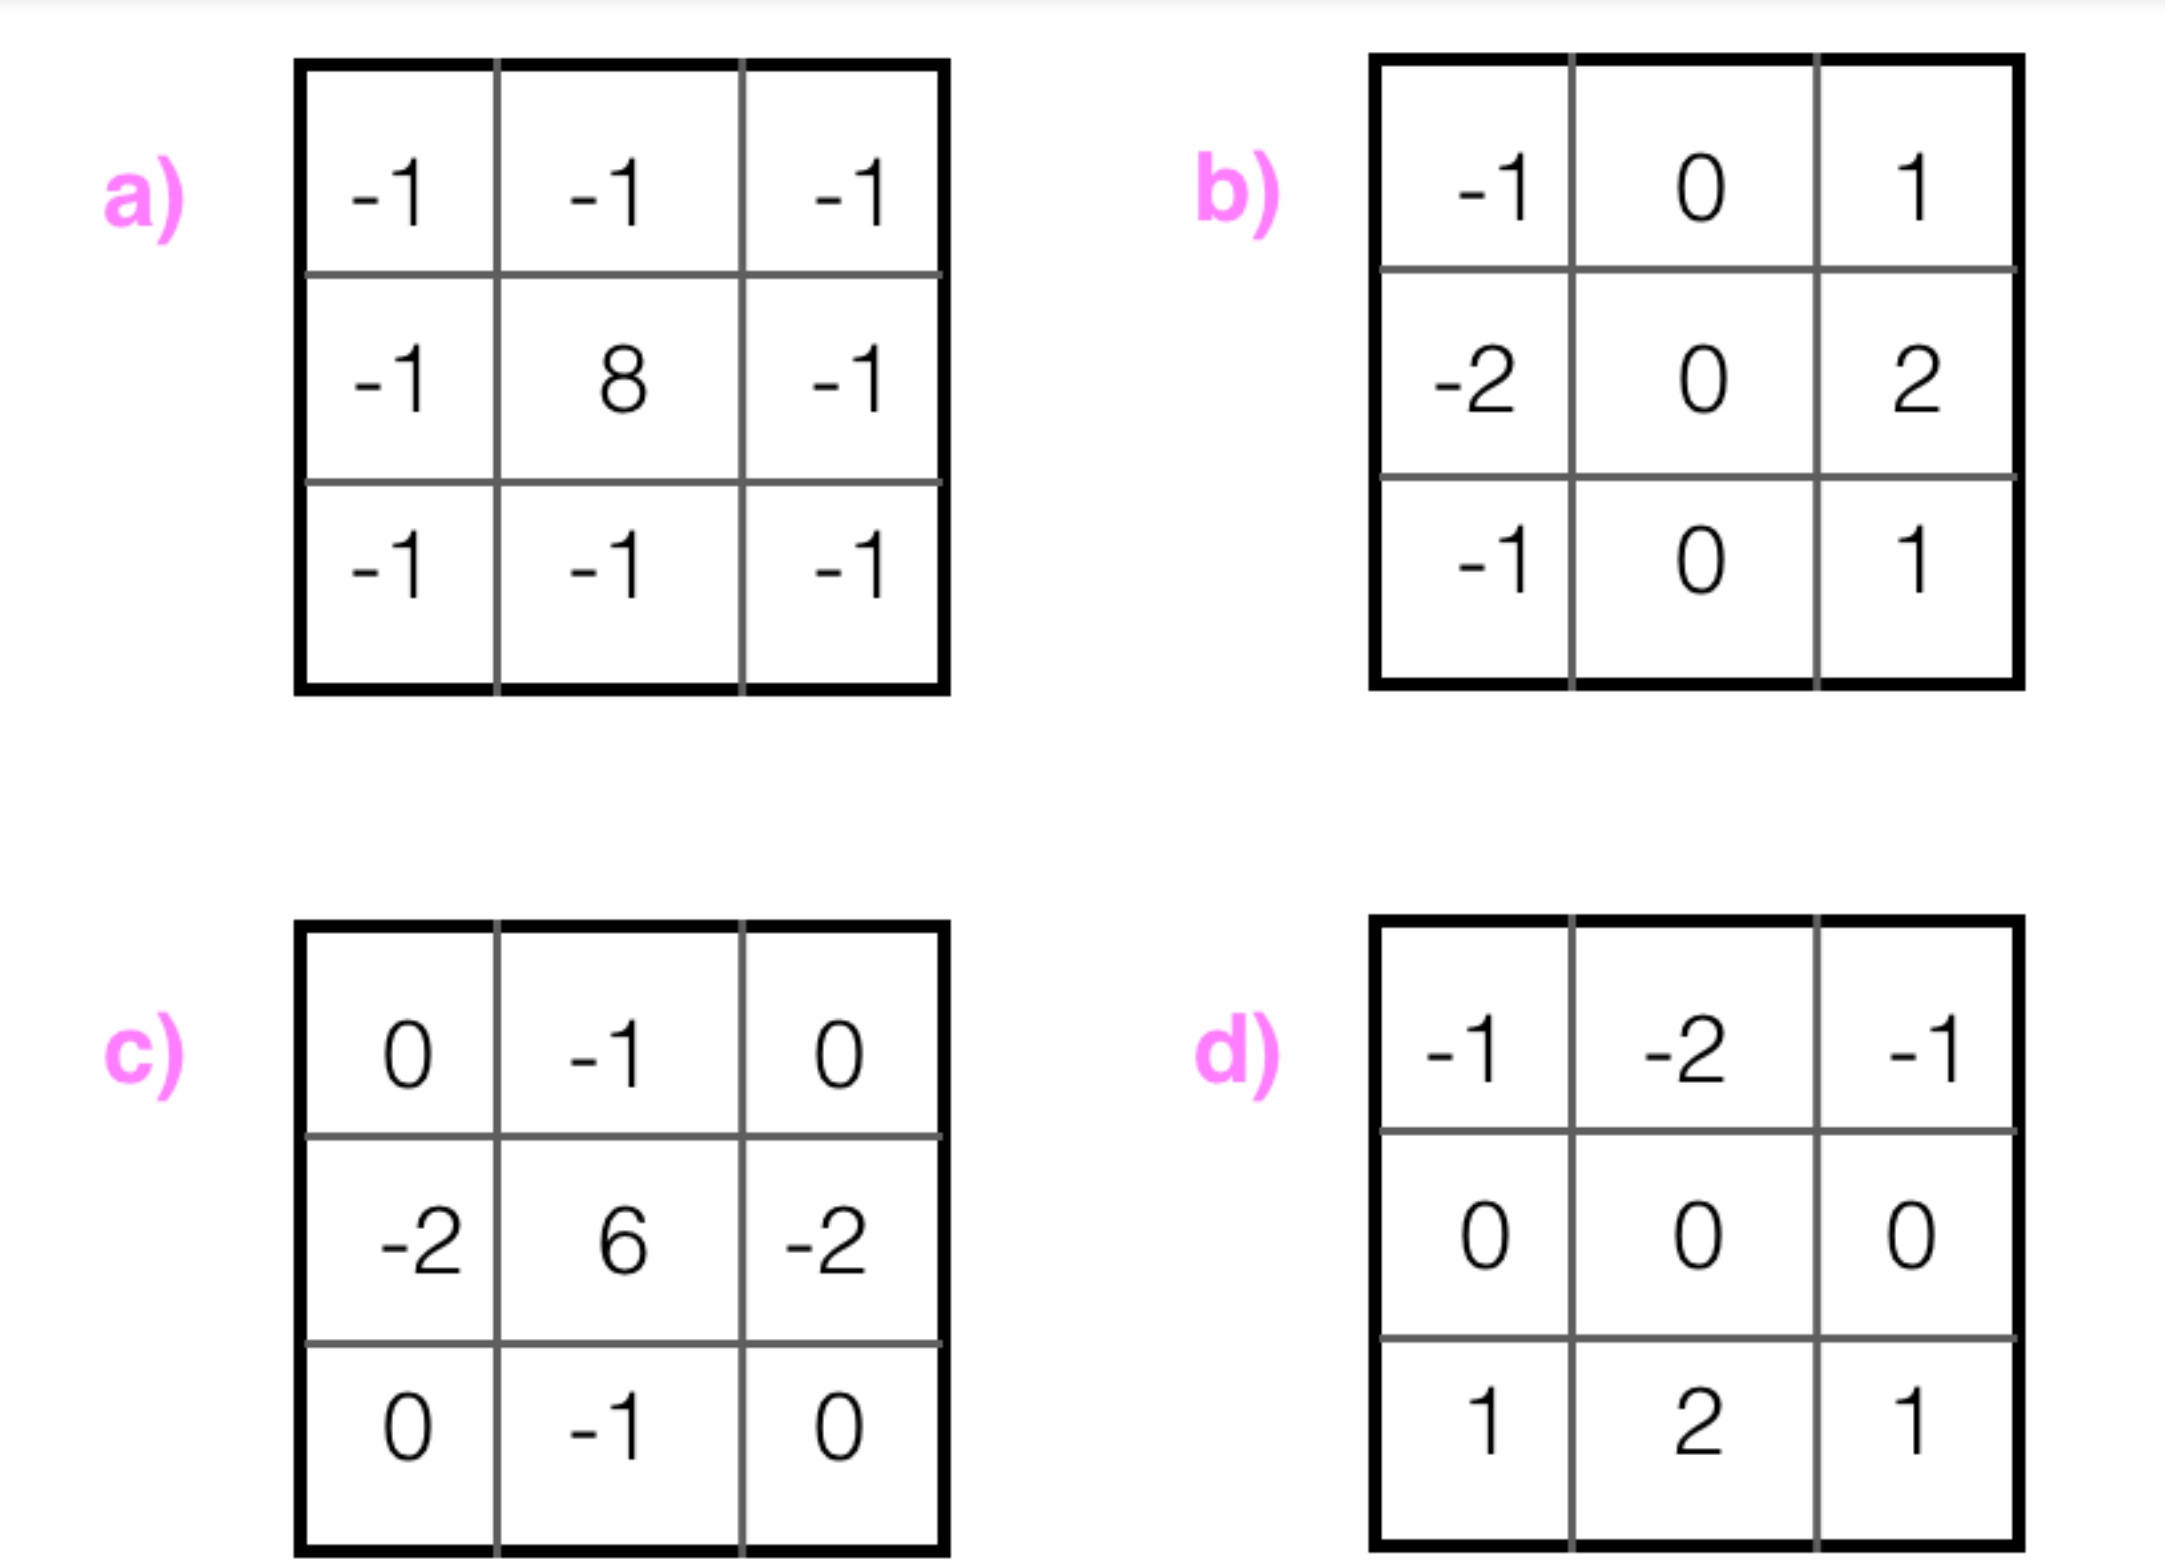

where:
- d) would be best for finding and enhancing **horizontal edges and lines** in an image
- b) would be best for finding and enhancing **vertical edges and lines** in an image

Filters d) and b) are also called **sobel filters**.

## Pooling
A technique to reduce sparsity of images after applying a kernel operation:
- It works by sliding a window over each feature map, just like convolution, but instead of applying a kernel we compute a summary statistic (for example the maximum or the mean)
- If we take the maximum, it is called **max-pooling**

## Concept abstraction
A block consisting of a convolutional layer followed by a max pooling layer (and an activation function) is the typical **building block** of a CNN:
- by combining multiple such blocks, the network learns to extract more and more complex information from the image

## Translation Variance
Combining multiple blocks allows the network to achieve **translation invariance**:
- it will be able to recognize the presence of an object wherever that object is translated within the image.

## Effective Receptive Fields
The concept of receptive field is that a pixel in the feature map of a deep layer is computed using information that originates from a large area of the input image, although it is mediated by other layers.

## Overview of building blocks CNN

Steps:
- Apply convolutional layers followed by pooling layers to recognize objects of interest
  - this results in a large number of **feature maps**
- Flatten them out in a long array
- Use a standard MLP to return an output of class scores

Check out [this website](https://adamharley.com/) to visualize convolutional neural networks.

## Quiz questions

What characterizes a convolutional layer?
- applies filters (kernels) to the input image
- extract spatial patterns from the input image
- extract color patterns from the input image

What does "translation invariance" mean?
- the network can recognize an object anywhere in the image

What is the role of a Max Pooling layer?
- reduce the size of the input image while preserving most of the information
- suppresses the noise in the output of a convolutional layer
- coupled with convolutional layers it allows the network to abstracts concepts and gain approximate translation invariance

What are the technical elements that make CNNs very good at dealing with image classification and other tasks involving images?
- Convolution to recognize patterns
- Pooling to favor invariance translation
- Mutiple layers to provide large effective fields to deep layers

## Glossary

CNN: Convolutional Neural Networks. A class of Neural Networks featuring local connectivity, weight sharing, and pooling operations.

MNIST: A dataset of handwritten digits of historical importance, commonly used nowadays for tutorials and learning.

Dataloader: Allows sequential or random iterations over a dataset or over a subset of a dataset.

Local connectivity: In the fully-connected layers present in a Multi-Layer Perceptron the neurons in a layer are connected to all neurons in the previous layer. Instead, in CNNs, a neuron is connected only to a small portion of contiguous neurons in the previous layer (or pixels in the input image).

Filters / Kernels: Small matrices of numbers, usually normalized to 1, that are applied to the input image during the convolution operation.

Convolution: The operation of sliding a kernel on an image or a feature map to produce a modified output.

Feature map: The result of applying a filter on an image or another feature map. One kernel/filter generates one feature map.

Pooling: The operation of sliding a window over the input image or a feature map and applying a function to the numbers present in that window (for example, taking the maximum).

Max Pooling: The operation of sliding a window over the input image or a feature map and applying a maximum function to the numbers present in that window.

Sobel filters: Specific types of filters that can isolate vertical and horizontal edges.

Effective receptive field (EFR): Generally, this is the region in the input image that contributes to the values of a pixel in a feature map deep in the network. More precisely, the effective receptive field is a matrix superimposed on the input image, where each element has a value proportional to the importance that a pixel in the input image has in determining the value of the pixel in the feature map deep in the network.

Flattening: The operation of taking an image or a feature map and changing it into a vector (or 1d array).

## Misc

- `nn.Linear(64, 100)` the first number represents the input layer and the second the output layer
- `model.eval()` will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!